In [4]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data

import viz_weights
%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
style.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load results from a directory

In [60]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_512'
fnames = sorted([fname for fname in os.listdir(out_dir) if not 'mnist' in fname and 
                 'numlays=4' in fname and 
                 'batchsize=100' in fname and not 'batchsize=1000' in fname])
#                   and 
#                  'numlays=4' in fname]) # and 
#                  'batchsize=100' in fname and 
#                  not 'batchsize=1000' in fname])
weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if fname.startswith('weights')]
results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights')]
results = pd.concat(results_list, axis=1).T.infer_objects()

save_dir = 'results_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
print('loaded', results_weights.shape[0], 'runs')

100%|██████████| 42/42 [00:03<00:00, 13.34it/s]

loaded 21 runs


In [ ]:
np.unique(results.num_layers)
np.unique(results.optimizer, return_counts=True)

# load results

In [8]:
pd_max = pd.read_pickle('max_corr_cifar_4+7lay_full_new.pkl') # max_corr_mnist_4+7lay.pkl

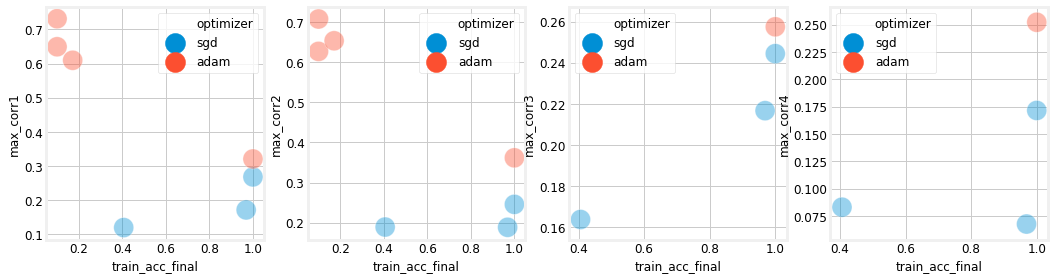

In [9]:
plt.figure(figsize=(16, 4))
R, C = 1, 4
plt.subplot(R, C, 1)
sns.scatterplot(pd_max['train_acc_final'], pd_max['max_corr1'], hue=pd_max['optimizer'], alpha=0.4)
plt.subplot(R, C, 2)
sns.scatterplot(pd_max['train_acc_final'], pd_max['max_corr2'], hue=pd_max['optimizer'], alpha=0.4)
plt.subplot(R, C, 3)
sns.scatterplot(pd_max['train_acc_final'], pd_max['max_corr3'], hue=pd_max['optimizer'], alpha=0.4)
plt.subplot(R, C, 4)
sns.scatterplot(pd_max['train_acc_final'], pd_max['max_corr4'], hue=pd_max['optimizer'], alpha=0.4)
plt.show()

In [ ]:
results[dset == 'cifar10'].shape

In [ ]:
df = pd_max.copy()
df = pd_max[pd_max['train_acc_final'] > 0.9]
df = pd_max[pd_max['num_layers']==4]
N = df.shape[0]
print(N)
x = np.repeat([1, 2, 3, 4], N)
y = np.concatenate([df['max_corr' + str(i)] for i in range(1, 5)])
opt = np.tile(df['optimizer'], 4)
sns.scatterplot(x, y, hue=opt, alpha=0.2)
plt.xlabel('layer for max corr')
plt.ylabel('max corr')
# print(df[['max_corr2', 'optimizer']])
plt.show()

In [ ]:
ax = sns.scatterplot(np.log10(df['lr']), df['max_corr1'], hue=df['optimizer'], alpha=0.4)
plt.show()

# set the params

optimizer     adam
lr           0.001
seed             0
Name: 16, dtype: object


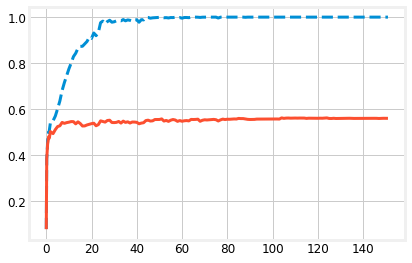

"\nrun_accs = results[(results['lr'] == vs['lr'])]\nrun_accs = run_accs[(run_accs['optimizer'] == vs['optimizer'])]\nrun_accs = run_accs[(run_accs['seed'] == vs['seed'])]\nrun_accs = run_accs[(run_accs['batch_size'] == vs['batch_size'])]\nrun_acc = run_accs.iloc[0]\n\n# print(run_accs['accs_train'][:30])\n\n\n\nrun = run.iloc[0]\n\n"

In [80]:
row = 7
epoch = 151
lay = 'fc.0.weight'
num_to_plot = 225
# vs = {'lr': 0.01, 'seed': 0, 'optimizer': 'adam'}
vs = {'lr': 0.001, 'seed': 0, 'optimizer': 'adam', 'batch_size': 100}

# filter out certain things
results_weights = results_weights[results_weights['shuffle_labels'] == False]


# filter appropriate run
run = results_weights[(results_weights['lr'] == vs['lr'])]
run = run[(run['optimizer'] == vs['optimizer'])]
run = run[(run['seed'] == vs['seed'])]
run = run[(run['batch_size'] == vs['batch_size'])]
idx = run.index


run_acc = results.iloc[idx].iloc[0]
run = run.iloc[0]
# load corresponding accs
# run_acc = results.iloc[idx][['optimizer', 'lr', 'seed']]
print(run_acc[['optimizer', 'lr', 'seed']])

# cast variables to correct types
run['num_layer'] = int(run['num_layers'])
run['hidden_size'] = int(run['hidden_size'])

plt.plot(run_acc['its'], run_acc['accs_train'], '--')
plt.plot(run_acc['its'], run_acc['accs_test'])
plt.show()

### plot weights

In [ ]:
epoch = 151
lay = 'fc.0.weight'
num_to_plot = 100


run = results_weights.iloc[0]
run['num_layer'] = int(run['num_layers'])
run['hidden_size'] = int(run['hidden_size'])

In [ ]:
# keys are epochs, vals are dicts of all weights
weights_dict_dict = run['weights']

# keys are layers, vals are weight values
weights_dict = weights_dict_dict[epoch]

# matrix of weights (output x input
w = weights_dict[lay]

viz_weights.plot_weights(w[:num_to_plot], dset='cifar10')
plt.show()

### reload the model

In [ ]:
import calc_max_corr

# load model
model = data.get_model(run)

train_loader, test_loader = data.get_data_loaders(run)
X_train, Y_train, X_test, Y_test = calc_max_corr.process_loaders(train_loader, test_loader)

# load in weights
weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
model.load_state_dict(weights_dict_tensors)
model = model.cuda()

In [55]:
X = X_train.cpu().numpy().reshape(X_train.shape[0], -1)[:1000]
Y = Y_train[:1000]
X = X[Y.argsort()] # sort X by class
W1 = model.state_dict()['fc.0.weight'].cpu().numpy()
Z = X @ W1.T

# Z[:, -50:] = np.tile(Y[Y.argsort()], 50).reshape(-1, 50)

In [ ]:
plt.figure(figsize=(12, 12), dpi=300)
plt.imshow(np.vstack((Z)), interpolation=None)
plt.xlabel('neuron num')
plt.ylabel('samples')
plt.grid('off')
plt.show()

plt.plot(Y[Y.argsort()])

### check the acc

In [ ]:
preds = model(Variable(X_train)).data.cpu().numpy().argmax(axis=1)
accs = preds==Y_train
print('mean acc', np.mean(accs))

In [ ]:
'''
mean_accs = np.zeros(10)
for c in range(10):
    idxs_c = Y_train == c
    mean_accs[c] = np.mean(accs[idxs_c])
plt.plot(range(10), mean_accs, 'o')
plt.xlabel('class')
plt.ylabel('acc')
'''

In [ ]:
X = X_train.cpu().numpy().reshape(X_train.shape[0], -1)
W = model.state_dict()['fc.0.weight'].cpu().numpy()
max_corr = max_corr_input(X, W)
print('mean max corr', np.mean(max_corr))
plt.hist(max_corr)
plt.axvline(np.mean(max_corr), color='red')
plt.show()